##### The latest version of this IPython notebook is available at [http://github.com/jckantor/CBE40455](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Geometric Brownian Motion

This notebook presents methods for modeling a financial time series as geometric Brownian motion. The basic outline is to:

1. Capture a data series.
2. Compute returns (we'll do both linear and log returns).
3. Test statistical properties. We need the returns to be independent and identically distributed (iid).
4. Fit distribution of returns to a normal distribution.
5. Perform simulations.

## Python Imports and Utility Functions

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import datetime
from pandas_datareader import data, wb

import requests

def get_symbol(symbol):
    """
    get_symbol(symbol) uses Yahoo to look up a stock trading symbol and 
    return a description.
    """
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)
    result = requests.get(url).json()
    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']

## Statistical Properties of Returns

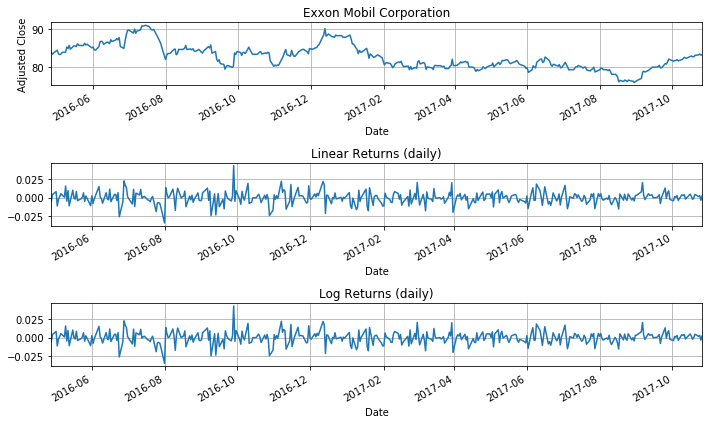

In [16]:
symbol = 'XOM'

# end date is today
end = datetime.datetime.today().date()

# start date is three years prior
start = end-datetime.timedelta(1.5*365)

# get stock price data
S = data.DataReader(symbol,"yahoo",start,end)['Adj Close']
rlin = (S - S.shift(1))/S.shift(1)
rlog = np.log(S/S.shift(1))

rlin = rlin.dropna()
rlog = rlog.dropna()

# plot data
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
S.plot(title=get_symbol(symbol))
plt.ylabel('Adjusted Close')
plt.grid()

plt.subplot(3,1,2)
rlin.plot()
plt.title('Linear Returns (daily)')
plt.grid()
plt.tight_layout()

plt.subplot(3,1,3)
rlog.plot()
plt.title('Log Returns (daily)')
plt.grid()
plt.tight_layout()

### Distribution of Returns

A basic assumption in developing developing stochastic price models is that the residuals are indepdendent and identically distributed (i.i.d.) random variates.  Here we show the results of several common statistical tests that would screen out non-i.i.d. random variates.

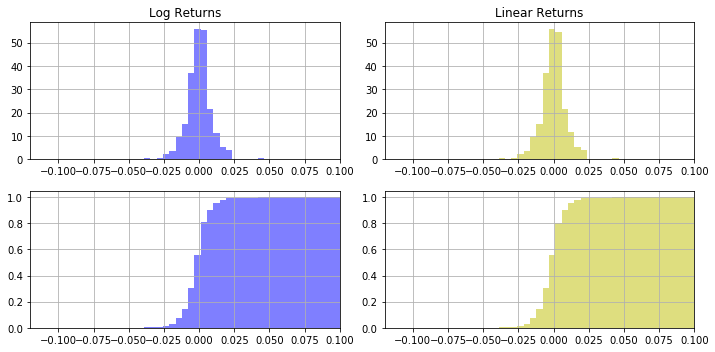

In [4]:
bins = np.linspace(-0.12,0.10,50)
plt.figure(figsize=(10,5))

plt.subplot(2,2,1)
rlog.hist(bins=bins, normed=True, color='b', alpha=0.5)
plt.xlim(bins.min(),bins.max())
plt.title('Log Returns')

plt.subplot(2,2,3)
rlog.hist(bins=bins, normed=True, cumulative=True, color='b',alpha=0.5)
plt.xlim(bins.min(),bins.max())

plt.subplot(2,2,2)
rlin.hist(bins=bins, normed=True, color='y', alpha=0.5)
plt.xlim(bins.min(),bins.max())
plt.title('Linear Returns')

plt.subplot(2,2,4)
rlin.hist(bins=bins, normed=True, cumulative=True, color='y',alpha=0.5)
plt.xlim(bins.min(),bins.max())

plt.tight_layout()

### Distribution of First Half versus Second Half of the Data Set

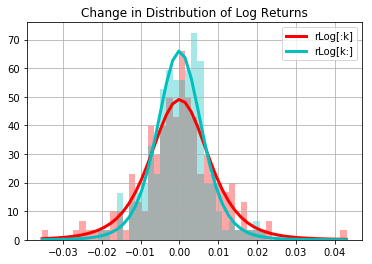

In [5]:
from scipy.stats import t

k = int(len(rlog)/2)
r = np.linspace(rlog.min(),rlog.max())

plt.figure();

param = t.fit(rlog[:k])
rlog[:k].hist(bins=r,normed=1,alpha=0.35,color='r')
plt.plot(r,t.pdf(r,df=param[0],loc=param[1],scale=param[2]),'r-',lw=3);

rlog[k:].hist(bins=r,normed=1,alpha=0.35,color='c')
param = t.fit(rlog[k:])
plt.plot(r,t.pdf(r,df=param[0],loc=param[1],scale=param[2]),'c-',lw=3);

plt.legend(['rLog[:k]','rLog[k:]'])
plt.title('Change in Distribution of Log Returns')

In [6]:
t.fit(rlog[:k].dropna())

(4.5753484075597921, 1.5449211864690811e-05, 0.0077030541214313112)

### Lag Plot of $r^{log}_{t+1}$ versus $r^{log}_t$

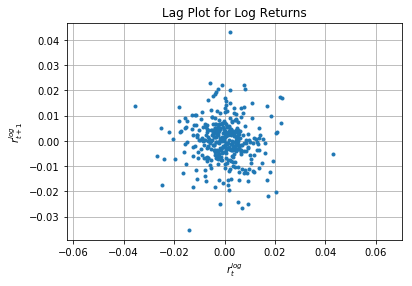

In [7]:
plt.plot(rlog[0:-1],rlog[1:],'.')
plt.axis('equal');
plt.xlabel('$r^{log}_{t}$')
plt.ylabel('$r^{log}_{t+1}$')
plt.grid()
plt.title('Lag Plot for Log Returns');

### Autocorrelation

/Users/jeff/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


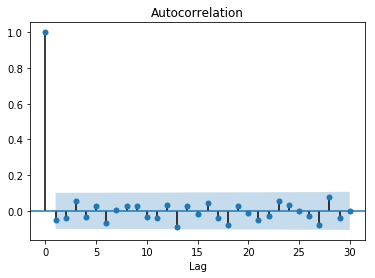

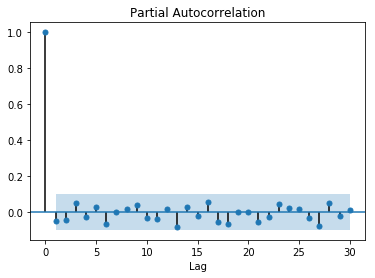

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(rlog,lags=min(30,len(rlog)));
plt.xlabel('Lag');
plot_pacf(rlog,lags=min(30,len(rlog)));
plt.xlabel('Lag');

## Fitting Returns to a Distribution

### Normal Distribution

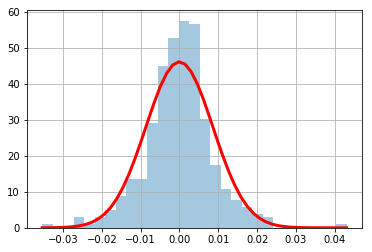

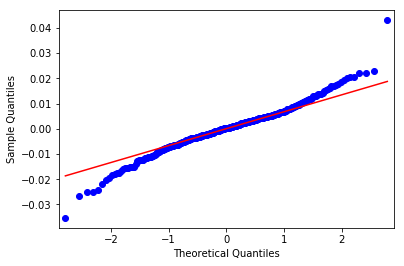

In [9]:
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot

r = np.linspace(rlog.min(),rlog.max())

plt.figure()
param = norm.fit(rlog)
rlog.hist(bins=int(1.5*np.sqrt(len(rlog))),normed=1,alpha=0.4)
plt.plot(r,norm.pdf(r,loc=param[0],scale=param[1]),'r-',lw=3)

plt.figure()
qqplot(rlog,line='q');

## Geometric Brownian Motion

$$S_{k+1} = S_k + \alpha h S_k + \beta \sqrt{h} S_k Z_k$$

where $Z_k \sim N(0,1)$ and $h$ corresponds to a sampling period of 1 'trading day'. There are typically 252 trading days in a calendar year, 63 trading days in a quarter, and 21 trading days in a month.

Defining return as

$$r^S_{k} = \frac{S_k - S_{k-1}}{S_{k-1}} = \alpha h + \beta \sqrt{h} Z_k$$

then the statistical model for $R_k$ becomes

$$r^S_{k} = \alpha h + \beta \sqrt{h} Z_k$$

For the case of Geometric Brownian Motion the hypothesis is that $r^S_k$ is a random variable drawn from a the normal distribution $r^S_k \sim N(\alpha h, \beta\sqrt{h}$).

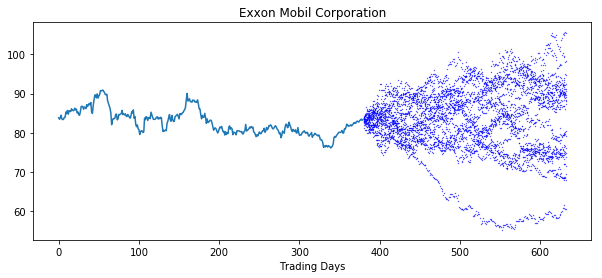

In [14]:
from scipy.stats import norm

plt.figure(figsize=(10,4))
plt.plot(S.values)
plt.title(get_symbol(symbol))
plt.xlabel('Trading Days')

N = 20     # number of realizations
T = 252    # simulation time horizon in trading days
h = 1      # time step in trading days

param = norm.fit(rlin)
alpha = param[0]/h
beta = param[1]/np.sqrt(h)

for n in range(0,N):
    P = S[-1]
    k = len(S)
    Plog = []
    klog = []
    for t in range(0,T):
        Z = norm.rvs(loc=alpha*h,scale=beta*np.sqrt(h))
        P += P*Z
        k += 1
        Plog.append(P)
        klog.append(k)
    plt.plot(klog,Plog,'b.',ms=0.6)


### Forecast Assuming a Normal Distribution of Returns

0.287147332863 0 112.939532061


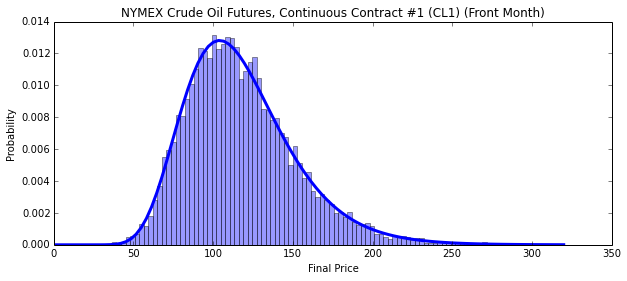

In [15]:
from scipy.stats import norm,lognorm

param = norm.fit(R)
alpha = param[0]
beta = param[1]

N = 10000
T = 252
h = 1

# Initialize P
Pgbm = array([S[-1]]*N)

# generator of random variates
Zgenerator = (array(norm.rvs(loc=alpha*h,scale=beta*sqrt(h),size=N)) for k in range(0,T))

for Z in Zgenerator:
    Pgbm += Pgbm*Z
    
figure(figsize=(10,4))
nbins = min(100,int(1.5*sqrt(N)))
hist(Pgbm,bins=nbins,normed=1,alpha=0.4,color='b');

shape,loc,scale = lognorm.fit(Pgbm,floc=0)
print shape,loc,scale
x=np.linspace(0,max(Pgbm),100)
pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale) # fitted distribution
plot(x,pdf_fitted,'b-',lw=3)
xlabel('Final Price')
ylabel('Probability');
title(description)